## Import Data

In [1]:
from datasets import load_dataset, Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cfg = "summarization_samples"
split = "data"

ds = load_dataset("pminervini/HaluEval", cfg, split=split)
print(ds)
print(ds.features)

# first 3 examples
for i in range(3):
    print(f"\nSample {i}:")
    for k, v in ds[i].items():
        print(f"{k}: {v}")

README.md: 0.00B [00:00, ?B/s]

summarization_samples/data-00000-of-0000(…):   0%|          | 0.00/25.5M [00:00<?, ?B/s]

Generating data split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['document', 'summary', 'hallucination'],
    num_rows: 10000
})
{'document': Value('string'), 'summary': Value('string'), 'hallucination': Value('string')}

Sample 0:
document: Marseille, France (CNN)The French prosecutor leading an investigation into the crash of Germanwings Flight 9525 insisted Wednesday that he was not aware of any video footage from on board the plane. Marseille prosecutor Brice Robin told CNN that "so far no videos were used in the crash investigation." He added, "A person who has such a video needs to immediately give it to the investigators." Robin's comments follow claims by two magazines, German daily Bild and French Paris Match, of a cell phone video showing the harrowing final seconds from on board Germanwings Flight 9525 as it crashed into the French Alps. All 150 on board were killed. Paris Match and Bild reported that the video was recovered from a phone at the wreckage site. The two publications described the supposed video, but 

## EDA

In [3]:
df = pd.DataFrame(ds)
print(df.columns)
print(df['hallucination'].value_counts(dropna=False))

Index(['document', 'summary', 'hallucination'], dtype='object')
hallucination
yes    5010
no     4990
Name: count, dtype: int64


In [4]:
# check for missing values
missing_values_count = df.isnull().sum()
print("Missing values per column:")
print(missing_values_count)

Missing values per column:
document         0
summary          0
hallucination    0
dtype: int64


In [5]:
# map labels to binary
df['label_binary'] = df['hallucination'].map({'yes': 1, 'no': 0})
print(df['label_binary'].value_counts(dropna=False))

label_binary
1    5010
0    4990
Name: count, dtype: int64


In [6]:
# length of documents
df['document_length'] = df['document'].apply(len)

min_doc_length = df['document_length'].min()
max_doc_length = df['document_length'].max()
mean_doc_length = df['document_length'].mean()
std_doc_length = df['document_length'].std()

print(f"Descriptive statistics for 'document' length:")
print(f"  Min length: {min_doc_length}")
print(f"  Max length: {max_doc_length}")
print(f"  Mean length: {mean_doc_length:.2f}")
print(f"  Standard deviation: {std_doc_length:.2f}")

Descriptive statistics for 'document' length:
  Min length: 294
  Max length: 11585
  Mean length: 3878.88
  Standard deviation: 2011.92


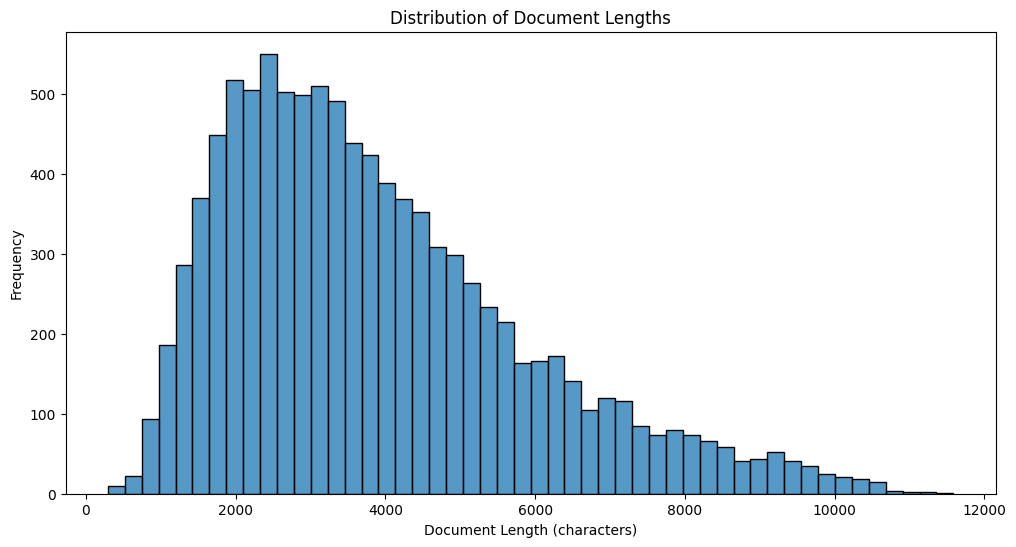

In [7]:
plt.figure(figsize=(12, 6))
sns.histplot(df['document_length'], bins=50)
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [8]:
# length of summaries
df['summary_length'] = df['summary'].apply(len)

min_summary_length = df['summary_length'].min()
max_summary_length = df['summary_length'].max()
mean_summary_length = df['summary_length'].mean()
std_summary_length = df['summary_length'].std()

print(f"Descriptive statistics for 'summary' length:")
print(f"  Min length: {min_summary_length}")
print(f"  Max length: {max_summary_length}")
print(f"  Mean length: {mean_summary_length:.2f}")
print(f"  Standard deviation: {std_summary_length:.2f}")

Descriptive statistics for 'summary' length:
  Min length: 51
  Max length: 2880
  Mean length: 367.22
  Standard deviation: 157.20


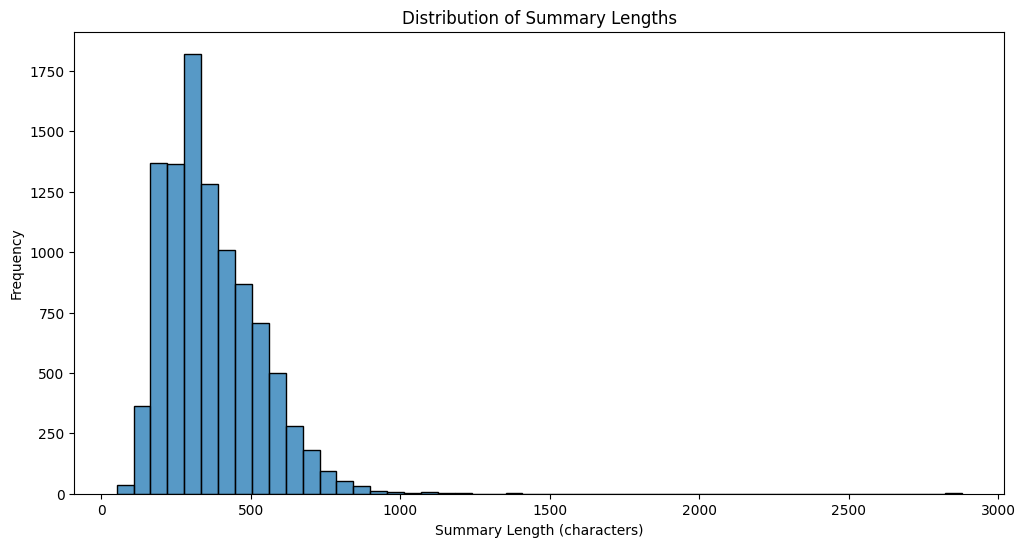

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['summary_length'], bins=50)
plt.title('Distribution of Summary Lengths')
plt.xlabel('Summary Length (characters)')
plt.ylabel('Frequency')
plt.show()

In [10]:
# investigate long summaries to ensure proper formatting
pd.set_option('display.max_colwidth', None)
print("Longest summaries:")
print(df.nlargest(3, 'summary_length')[['summary', 'summary_length']])
pd.reset_option('display.max_colwidth') # Reset to default after displaying

Longest summaries:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

The entries seem legitimate and no issues such as formatting noise. There's no need to remove those entries.

## Prepare Data and Export

In [11]:
# map labels to binary
df['label_binary'] = df['hallucination'].map({'yes': 1, 'no': 0})
print(df['label_binary'].value_counts(dropna=False))

label_binary
1    5010
0    4990
Name: count, dtype: int64


In [13]:
df.to_csv('halueval_summarization_processed.csv', index=False)
print("Dataset saved to 'halueval_summarization_processed.csv'")

Dataset saved to 'halueval_summarization_processed.csv'


## Add In Paraphrasing

In [12]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

In [13]:
documents = df['document'].tolist()
summaries = df['summary'].tolist()
y_true_bin = df['label_binary'].to_numpy(int)
y_true_str = df['hallucination'].tolist()

In [14]:
X = df[['document', 'summary']]
y = df['label_binary']

# Split data into training and testing sets (e.g., 80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 8000 samples
Validation set size: 1000 samples
Testing set size: 1000 samples


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [19]:
model_name = "Vamsi/T5_Paraphrase_Paws"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [20]:
def paraphrase_text(text, max_length, num_beams=4):
  if not text or text.strip() == "":
    return text

  input_text = "paraphrase: " + text + " </s>"

  encoding = tokenizer(
      input_text,
      max_length=max_length,
      padding="longest",
      truncation=True,
      return_tensors="pt"
  ).to(device)

  with torch.no_grad():
    outputs = model.generate(
        **encoding, # Corrected: should be 'encoding' not 'enumerate'
        max_length=max_length,
        num_beams=num_beams,
        num_return_sequences=1,
        early_stopping=True
    )

  # Corrected: use tokenizer.decode for a single sequence output
  paraphrased_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return paraphrased_text.strip()

In [21]:
from tqdm.auto import tqdm
tqdm.pandas() # This line registers .progress_apply() for pandas DataFrames and Series.

def add_paraphrased_summary(example):
  summary = example["summary"]
  # The paraphrase_text function requires a max_length argument.
  # Using 1024 as a reasonable maximum length for transformer models.
  example["summary_paraphrased"] = paraphrase_text(summary, max_length=1024)
  return example

# Apply the function to each row of X_test using progress_apply for a progress bar.
# The `map` method is not suitable for row-wise operations on a DataFrame.
test_paraphrase = X_test.progress_apply(add_paraphrased_summary, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
test_paraphrase.to_csv('halueval_summarization_paraphrased.csv', index=False)

In [23]:
test_paraphrase.head()

,document,summary,summary_paraphrased
4343,It has been 40 years since the historic evacua...,Ba Van Nguyen piloted a military helicopter on...,Ba Van Nguyen piloted a military helicopter on...
1794,What if someone took your greatest insecuritie...,Dove's latest ad campaign shows actresses bull...,Dove's latest ad campaign shows actresses bull...
708,"So, you'd like a ""Full House"" reunion and spin...","Show will return with a one-hour special, foll...","The show will return with a one-hour special, ..."
3383,Ahead of a weekend featuring drama from the Ba...,Crystal Palace is set to face West Bromwich Al...,Crystal Palace is set to face West Bromwich Al...
4534,The dawn of a new era of space travel may be u...,His Blue Origin company completed a successful...,His Blue Origin company completed a successful...
